## Import needed libraries

In [3]:
import cv2 as cv
from cv2 import pyrDown, Sobel, warpAffine

## Read the consecutive frames

In [25]:
I1 = cv.imread("./resources/frame1.png", flags=cv.IMREAD_GRAYSCALE)
I2 = cv.imread("./resources/frame2.png", flags=cv.IMREAD_GRAYSCALE)

# Pyramid construction

In [33]:
def constructImagePyramid(I1, I2, L):
    pyramid1 = [I1]
    pyramid2 = [I2]
    
    for l in range(1, L):
        prev1 = pyramid1[l-1]
        prev2 = pyramid2[l-1]
        pyramid1.append(cv.pyrDown(prev1))
        pyramid2.append(cv.pyrDown(prev2))

    return pyramid1, pyramid2


In [36]:
pyramid1 = constructImagePyramid(I1, I2, 4)[0]
for img in pyramid1:
    print(img.shape)

(768, 1368)
(384, 684)
(192, 342)
(96, 171)


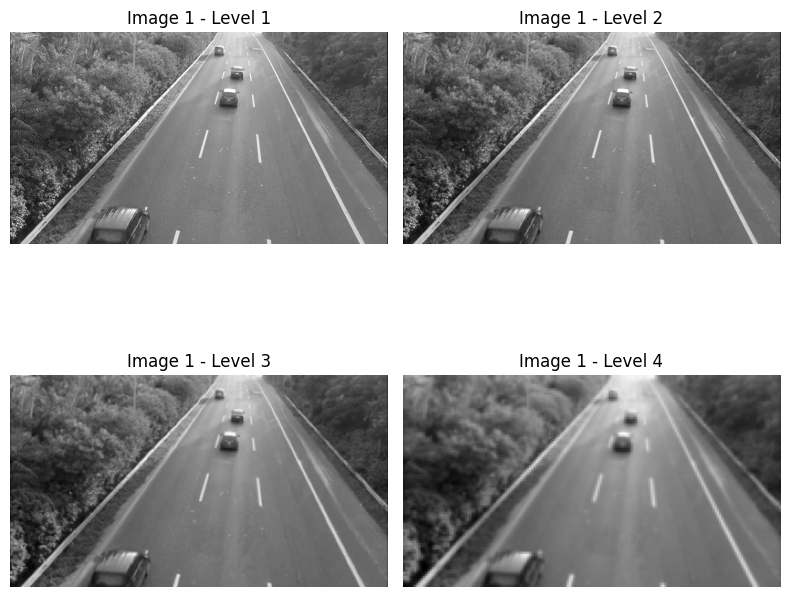

In [37]:
import matplotlib.pyplot as plt

# Display them in a 2x2 grid
plt.figure(figsize=(8, 8))

for idx, img in enumerate(pyramid1, start=1):
    plt.subplot(2, 2, idx)
    plt.imshow(img, cmap='gray')
    plt.title(f'Image 1 - Level {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()
    

# iterative Lucas-Kanade method

In [ ]:
def pyramidalLk(I1, I2, L, w, K):
    raise NotImplementedError

## Propagate flow estimates from coarse to fine levels

In [ ]:
def Propagate_from_coarse_to_fine():
    raise NotImplementedError

## Compute the optical flow

In [ ]:
def compute_optical_flow():
    raise NotImplementedError